<a href="https://colab.research.google.com/github/shubhamkarkar/DesignOptimization2021Fall/blob/main/Homework/HW-3/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shubham Ashok Karkar  

ASU ID : 1223319344  

MAE-598 Design Optimization

Homework-3


---
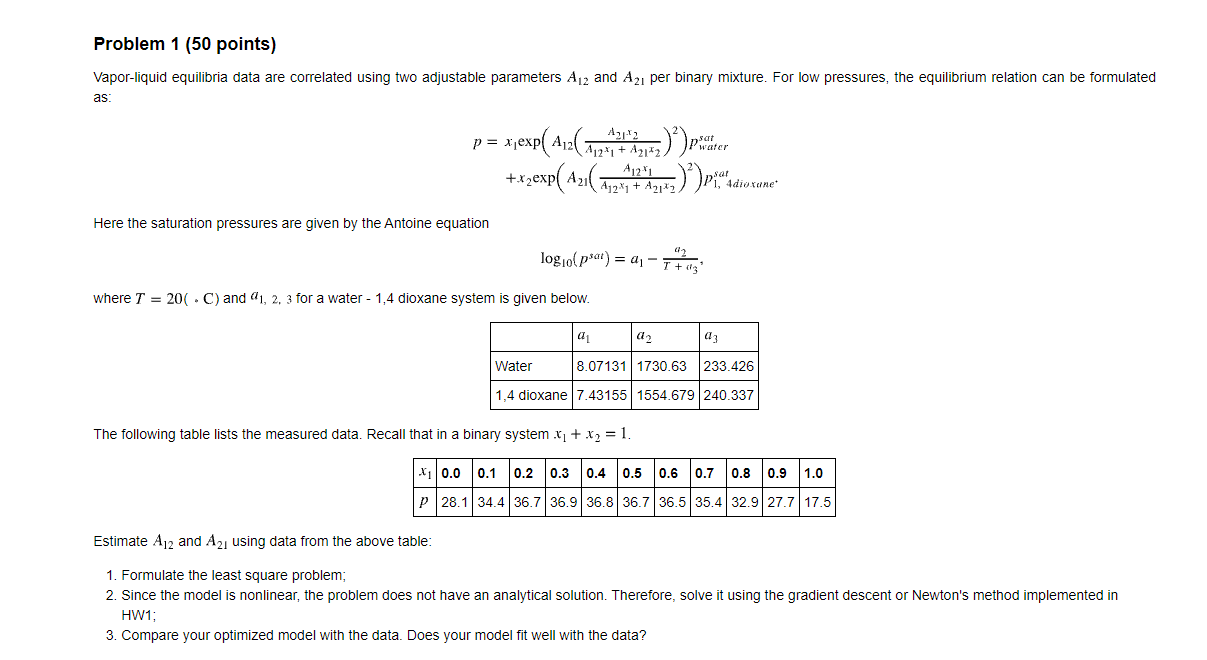

**Solution :**
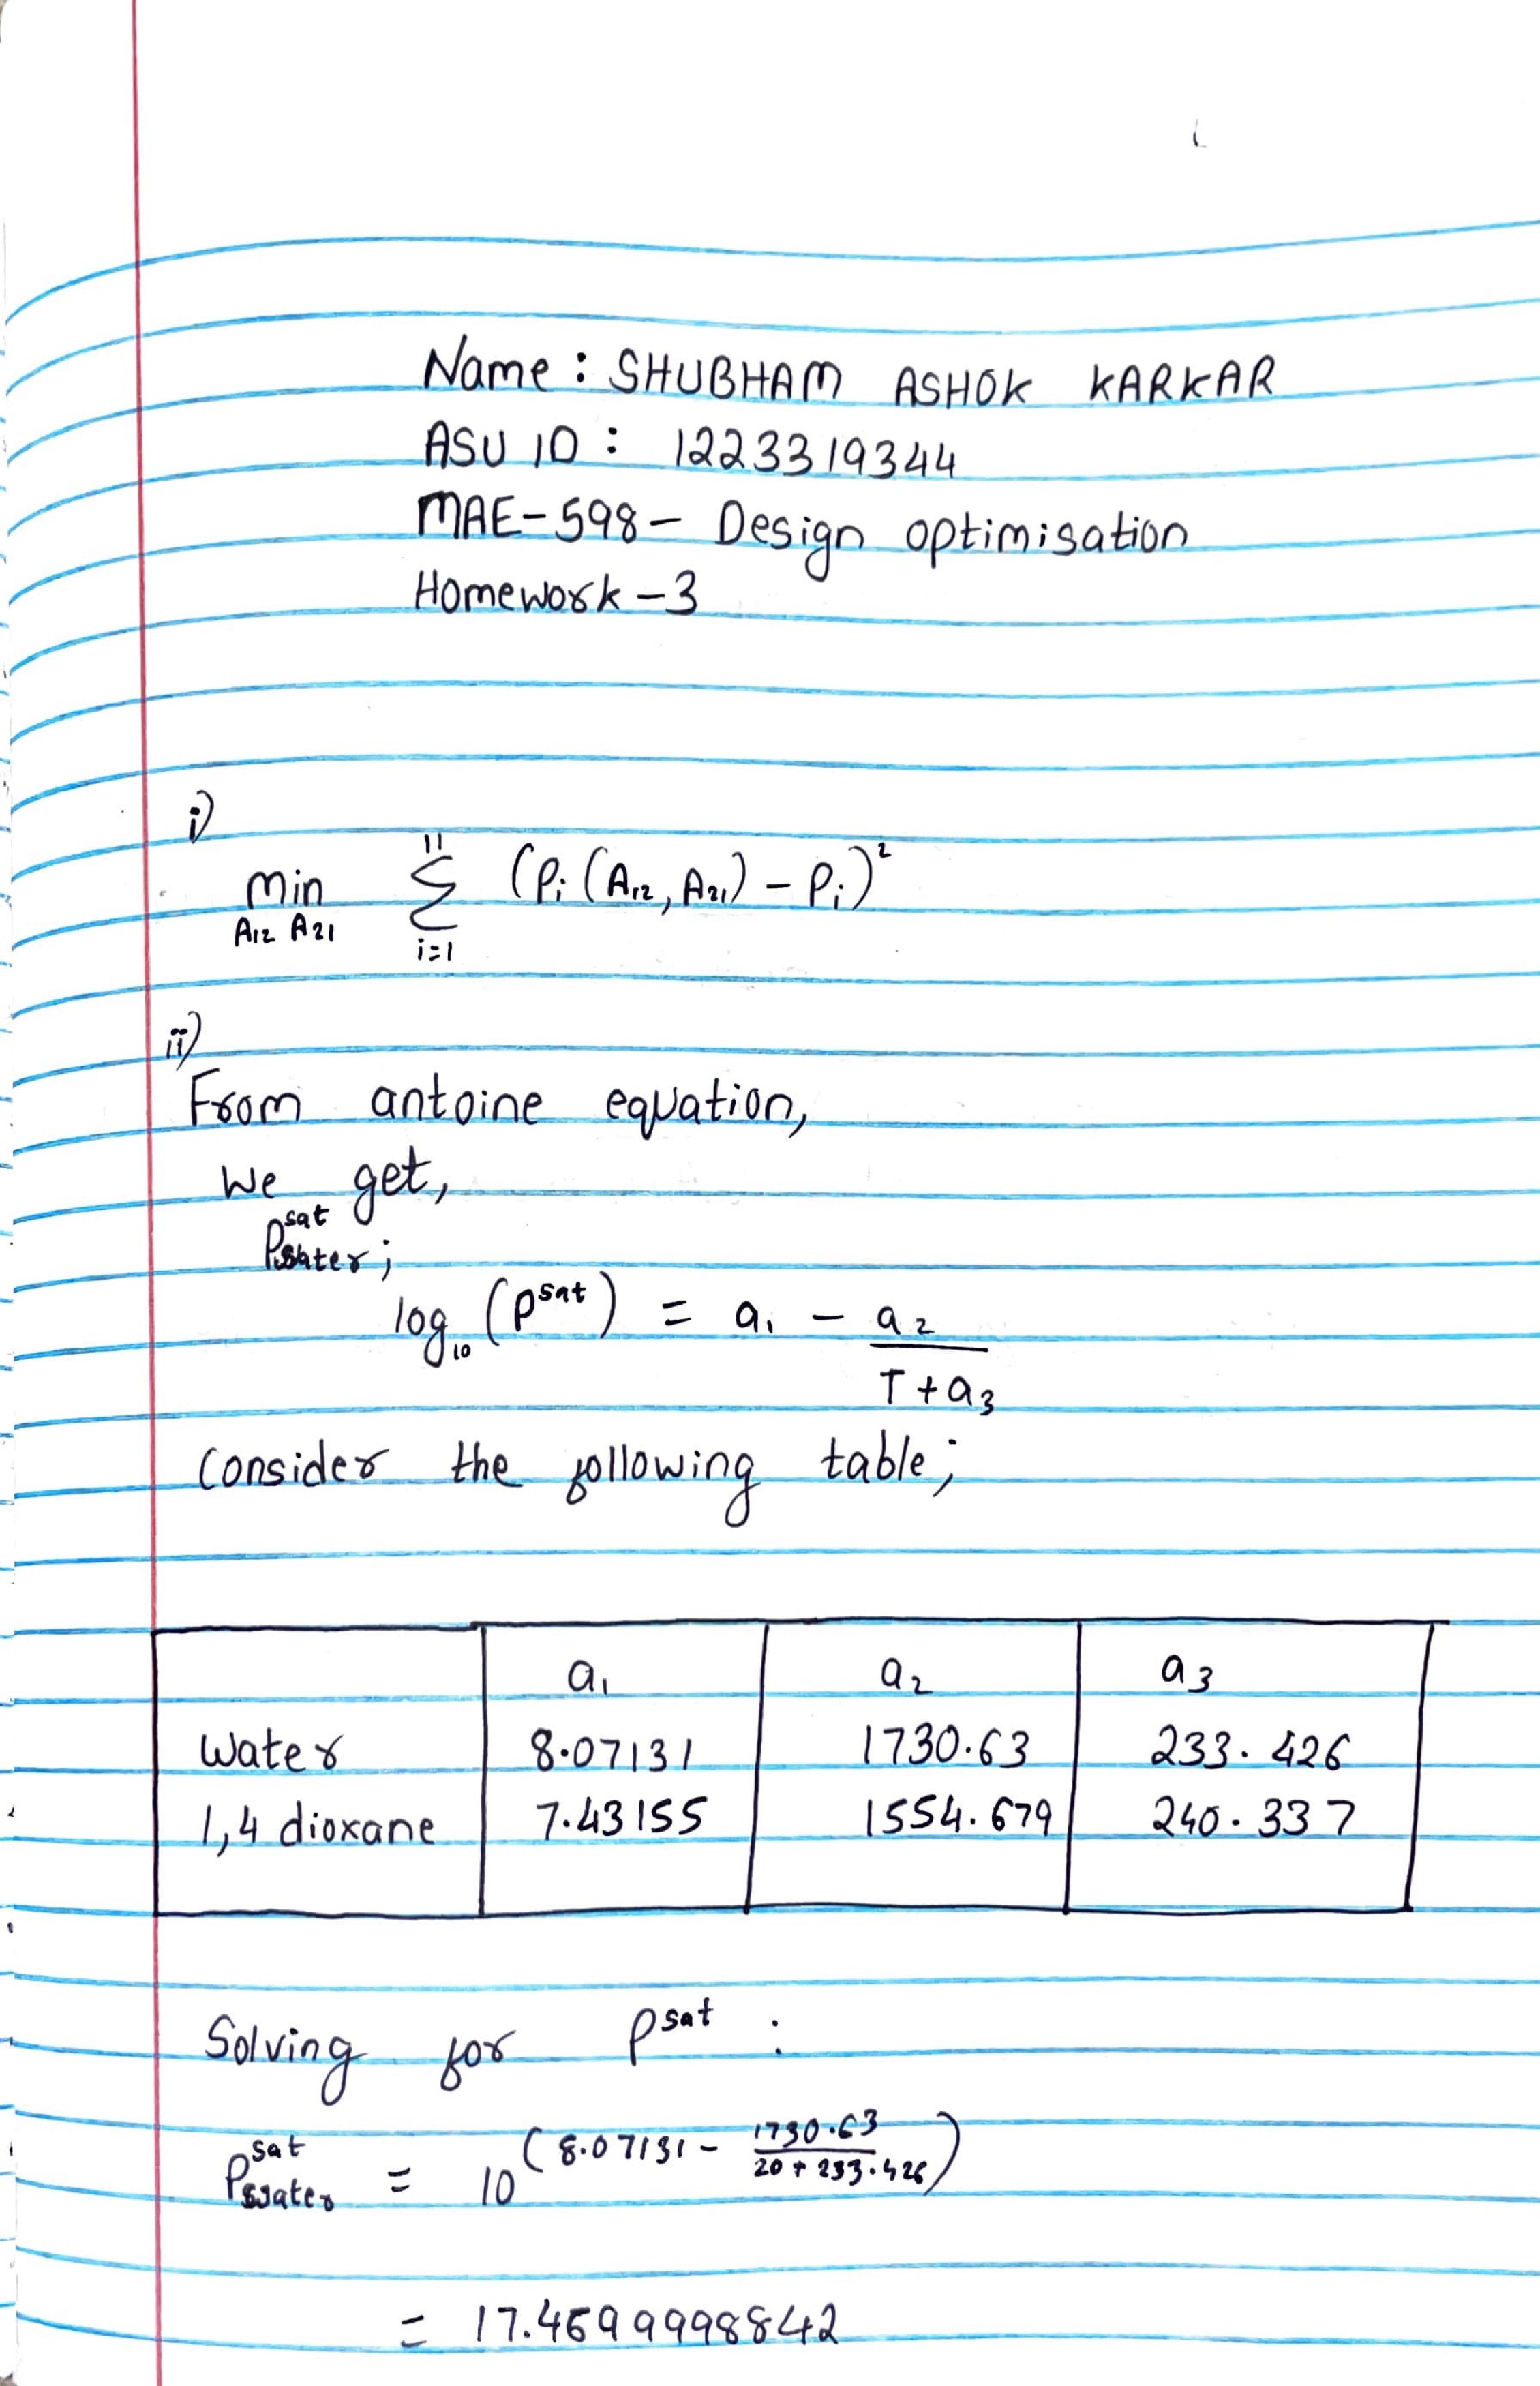

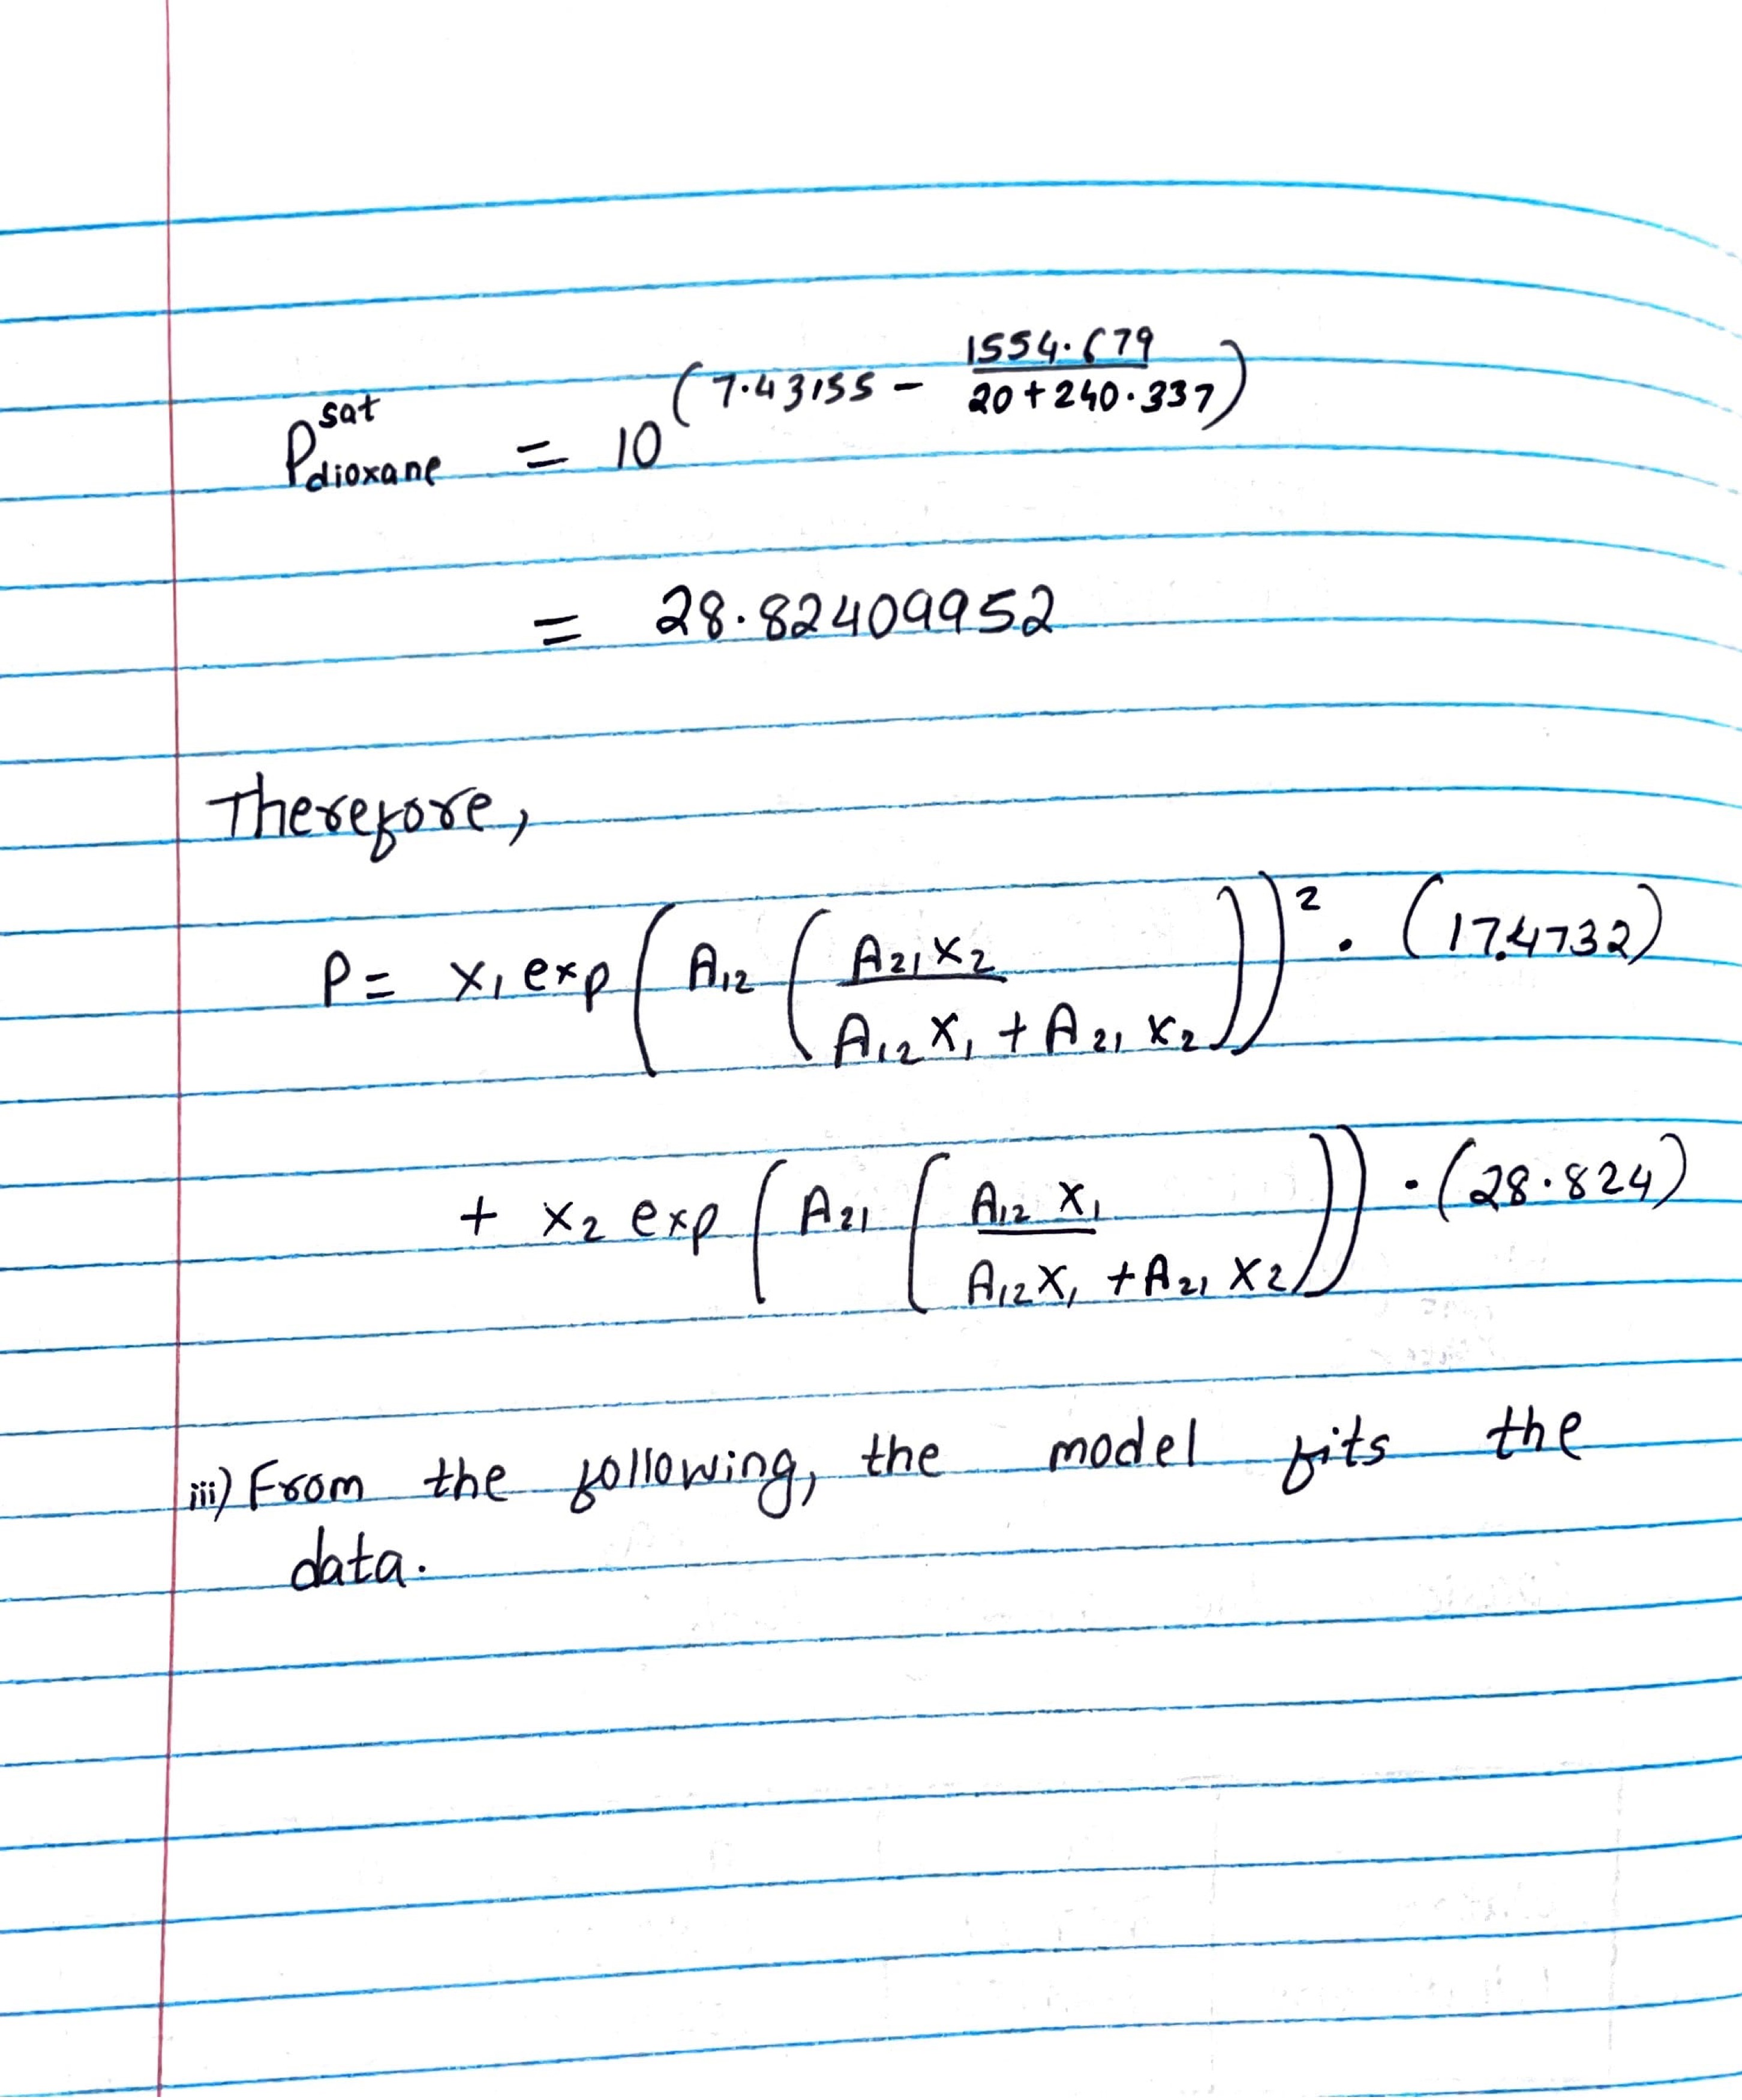

In [111]:

import numpy as np
import importlib
import torch as t

from torch.autograd import Variable


#Calculating the saturation pressure:

a_W = [8.07131, 1730.63,  233.426]
a_14dio = [7.43155, 1554.679, 240.337]

T_val=20   #(T = 20 & a_{1,2,3} for a water - 1,4 dioxane system)
p_sat_W = sat_pressure(T_val, a_W)
p_sat_14dio = sat_pressure(T_val, a_14dio)

print('p_sat_water =',p_sat_W)
print('p_sat_1,4dioxane =',p_sat_14dio )


A = Variable(t.tensor([0.6, 0.4]), requires_grad=True)

#observations:
x_obs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_obs = [28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]

#For Gradient Descent
for i in range(max_iter_num):
    loss = loss_loop(x_obs, p_obs, A, p_sat_water, p_sat_dio)
    loss.backward()
    
    
    #Hence, we don't need this algorithm to be differential with x.
    with t.no_grad():
        A -= a * A.grad
        
        if t.norm(A.grad) < e:
            break
        A.grad.zero_()
        
A_est = A.data.numpy()
print('A12=',A_est[0])
print('A21=',A_est[1]) 
print("Value of loss function:")     
print(loss.data.numpy())



p_sat_water = 17.47325208459706
p_sat_1,4dioxane = 28.824099527405245
A12= 1.9584197
A21= 1.6891853
Value of loss function:
0.6701896


Part-3

After comparing the model with the data, we can say that the fit tends to be accurate from graphical.


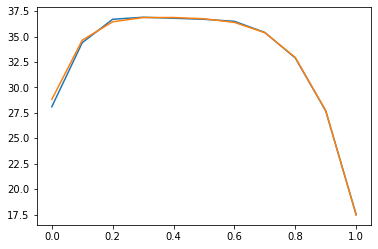

In [109]:
## Graph for comparison:
import matplotlib.pyplot as plt
plt.plot(x_obs, p_obs)
plt.plot(x_obs, p_est)

## Q-2. 

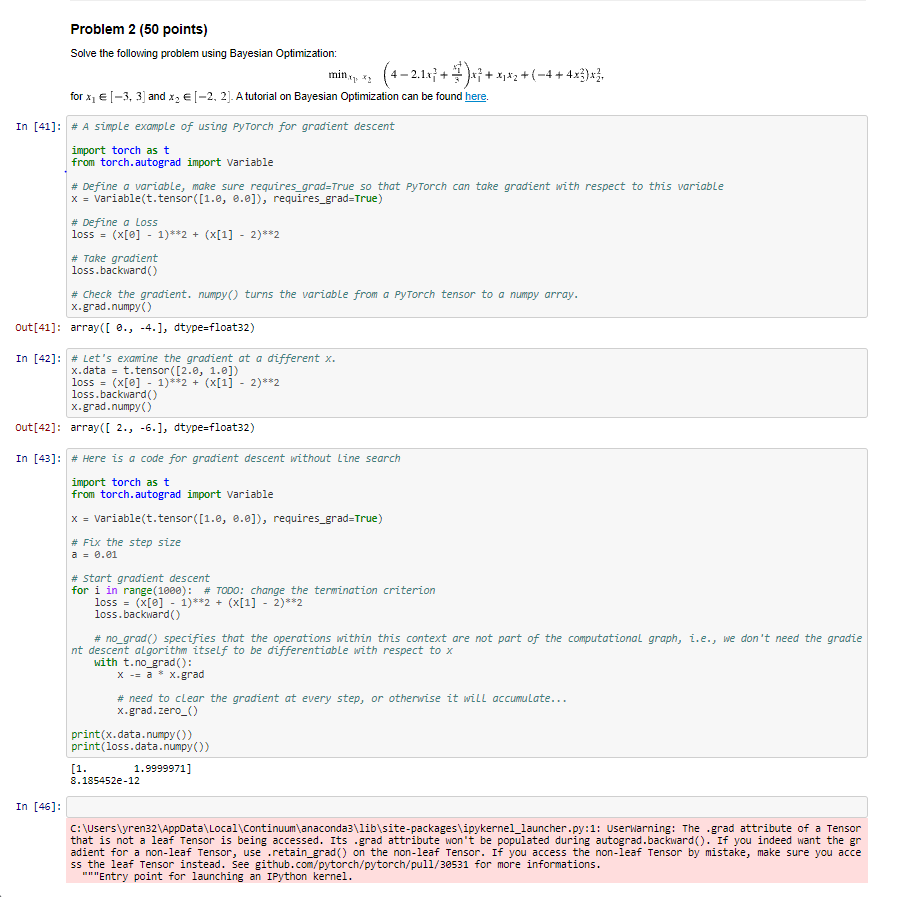

Optimized value of x1= -0.1404926257340744
Optimized value of x2= 0.7137300324516422
Corresponding value of loss function for optimized x1, x2 = -1.0217824478784499


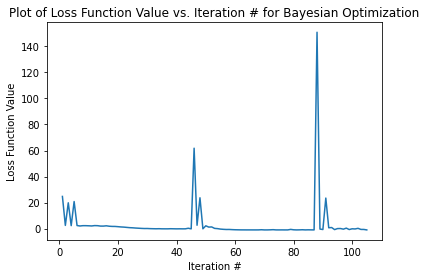

In [131]:
#introducing toolkit for bayesian optimization 
import sklearn.gaussian_process as gp
# Choosing the number of iterations to run (I arbitrarily chose 100)
n_iters = 100

# Choosing the number of pre-samples to the loss function (I arbitrarily chose 5)
n_pre_samples = 5

# Defining the function to be minimized
sample_loss = lambda x: (4-2.1*(x[0]**2)+(x[0]**4)/3)*x[0]**2+x[0]*x[1]+(-4+4*x[1]**2)*x[1]**2

# Defining the parameter bounds for x1 and x2
bounds = np.array([[-3,3],[-2,2]])

# Running the bayesian optimisation function with the predefined parameters, making sure to not use pure random search
xbaye, lossbaye = bayesian_optimisation(n_iters, sample_loss, bounds, x0 = None, n_pre_samples = 5,gp_params = None, random_search = None, alpha=1e-5, epsilon=1e-7)

# Creating a plot showing the progression of the optimization function as it optimized x1 and x2
plt.plot(np.linspace(1,(n_iters+n_pre_samples),(n_iters+n_pre_samples)), lossbaye)
plt.title('Plot of Loss Function Value vs. Iteration # for Bayesian Optimization')
plt.xlabel('Iteration #')
plt.ylabel('Loss Function Value')

# Printing the optimized value of x1 and x2 alongside the corresponding value for the loss function 
print('Optimized value of x1=', xbaye[-1,0])
print('Optimized value of x2=', xbaye[-1,1])
print('Corresponding value of loss function for optimized x1, x2 =', lossbaye[-1])


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.h

Taking the given values and considering the following graph
[-0.99364309 -0.41131547]
2.259445950550752


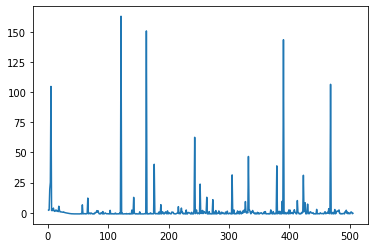

In [140]:
#Taking a reference by Thomas Huijskens code:
""" gp.py
Bayesian optimisation of loss functions.
"""
# Code modified from Bayesian Optimization tutorial "Bayesian optimization with scikit-learn" 
# https://github.com/thuijskens/bayesian-optimization   - Linked in tutortial

import numpy as np
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize


def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=False, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=False, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

n = 500
nPreSamples = 5

Eqn = lambda x: (4-2.1*x[0]**2+((x[0]**4)/3))*x[0]**2+x[0]*x[1]+(-4+4*(x[1]**2))*(x[1]**2)
bounds = np.array([[-3, 3],[-2,2]])
bOp1, bOp2 = bayesian_optimisation(n, Eqn, bounds, x0=None, n_pre_samples=5, gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7)

plt.plot(np.linspace(1,(n+nPreSamples),(n+nPreSamples)),bOp2)
plt.show

print("Taking the given values and considering the following graph")

print(bOp1[0])
print(bOp2[1])


Solving the same problem by installing and using bayesian_optimisation model

In [153]:

from bayes_opt import BayesianOptimization

# I find the minmize function by using maximum and multplut the function by -1 to find the minimum 
def function(x, y):
    return -((4-2.1*x**2+(x**4)/3)*x**2+x*y+(-4+4*y**2)*y**2)
pbounds = {'x': (-3, 3), 'y': (-2, 2)}

optimizer = BayesianOptimization(f=function,pbounds=pbounds,random_state=1)

optimizer.maximize(init_points=2,n_iter=500)
print(optimizer.max)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        |  0.265    | -0.4979   |  0.8813   |
|  2        | -110.1    | -2.999    | -0.7907   |
|  3        | -14.48    | -2.347    | -0.5245   |
|  4        | -3.791    |  1.98     |  0.6406   |
|  5        | -3.61     | -2.104    |  0.5152   |
|  6        | -20.73    | -2.484    |  1.035    |
|  7        | -8.23     | -0.6262   | -1.354    |
|  8        | -12.31    |  2.326    | -0.2112   |
|  9        |  0.06557  | -0.4062   | -0.5919   |
|  10       | -0.4875   |  0.6594   | -0.4285   |
|  11       |  0.262    |  0.3192   |  0.8082   |
|  12       | -5.892    | -2.109    | -0.3733   |
|  13       | -33.52    | -2.599    |  0.1371   |
|  14       | -2.428    | -0.9648   | -0.9004   |
|  15       | -0.1915   | -1.854    |  0.6938   |
|  16       | -19.85    |  2.459    | -0.3357   |
|  17       | -1.168    | -1.992    |  0.7364   |
|  18       | -0.8146   | -1.931    |  0.6334   |
